##掛載雲端硬碟


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##更改檔案所在路徑

In [ ]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/Colab\ Notebooks/EAI_Lab4_2023

## Import library

In [1]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數(填空)

In [2]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################

# LAMBDA = 0
# LAMBDA = 1e-5
LAMBDA = 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

# WEIGHT_PATH = '/content/drive/MyDrive/Colab Notebooks/model_best.pth'
# WEIGHT_PATH = 'weights/train0.pth'
# WEIGHT_PATH = 'weights/train1.pth'
WEIGHT_PATH = 'weights/train2.pth'


In [3]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [4]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 定義模型與載入訓練好的權重

In [5]:
model = vgg()
if CUDA:
    model.cuda()

## 設定Optimizer，這裡使用Stocastic Gradient Descent

In [6]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 使用論文中稀疏化的方式更新參數(填空)

In [7]:
def updateBN(LAMBDA):
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
          m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))  # L1

## 載入預先定義好的模型與參數

In [8]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch']
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

## 定義訓練跟測試函數

In [8]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch, LAMBDA=0):
    model.train()
    total, correct = 0, 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN(LAMBDA)
        optimizer.step()

        total += len(data)
        correct += (output.max(1)[1].view(target.size()) == target).sum().item()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    train_acc = correct / total
    return train_acc



#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
train_acc_list = []
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train_acc = train(epoch, LAMBDA)
    train_acc_list.append(train_acc)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    os.makedirs(os.path.dirname(WEIGHT_PATH), exist_ok=True)
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.296834
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.733687
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.577587
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.596001
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.501671

Test set: Average loss: 1.4214, Accuracy: 4832/10000 (48.3%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.105004
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.216898
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.007213
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.147375
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.042875

Test set: Average loss: 1.0680, Accuracy: 6428/10000 (64.3%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.985054
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.828863
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.783534
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.720479
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.837410

Test set: Average loss: 0.9197, Accuracy: 6910/10000 (69.1%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.768200

## 繪製Sparsity-Training結果圖

In [ ]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt

def plot_train_acc(train_acc_list, title='Accuracy v.s. Epoch', filename=None):
    plt.plot(range(1, EPOCHS+1), train_acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    if filename:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)
    plt.show()

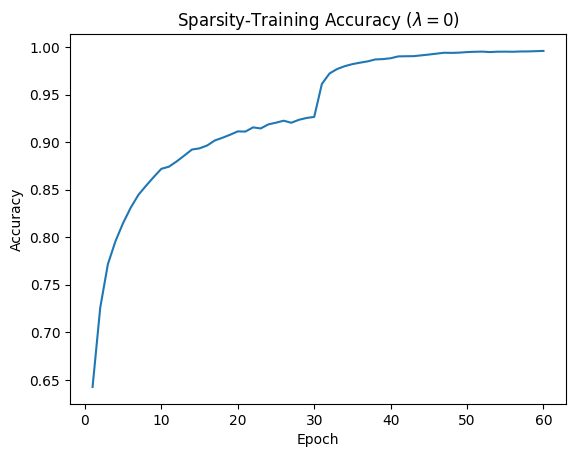

In [ ]:
plot_train_acc(train_acc_list, 'Sparsity-Training Accuracy ($\lambda = 0$)', 'images/sparse_train_acc_0.png')

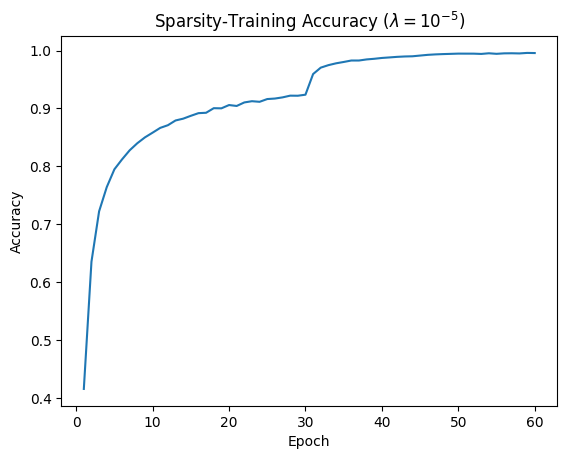

<Figure size 640x480 with 0 Axes>

In [11]:
plot_train_acc(train_acc_list, 'Sparsity-Training Accuracy ($\lambda = 10^{-5}$)', 'images/sparse_train_acc_1.png')

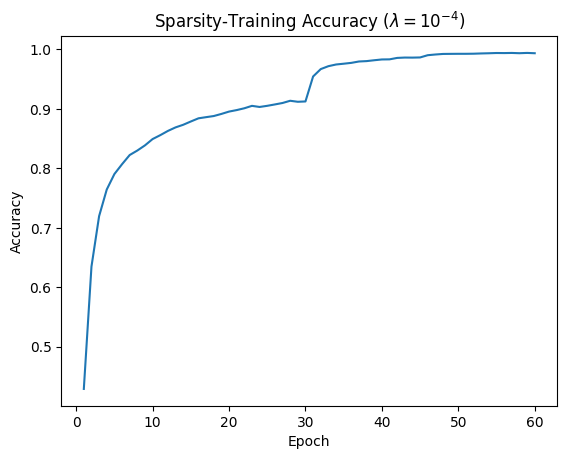

<Figure size 640x480 with 0 Axes>

In [10]:
plot_train_acc(train_acc_list, 'Sparsity-Training Accuracy ($\lambda = 10^{-4}$)', 'images/sparse_train_acc_2.png')

## 繪製scaling factor 分布圖

In [ ]:
#繪製 scaling factor 分布圖
import matplotlib.pyplot as plt

def plot_scaling_factor(model, title='Distribution of BatchNorm Scaling Factor', filename=None):
    BN_weights = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            BN_weights += list(m.weight.data.cpu().numpy())
    plt.hist(BN_weights, bins=50)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(title)
    if filename:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)
    plt.show()

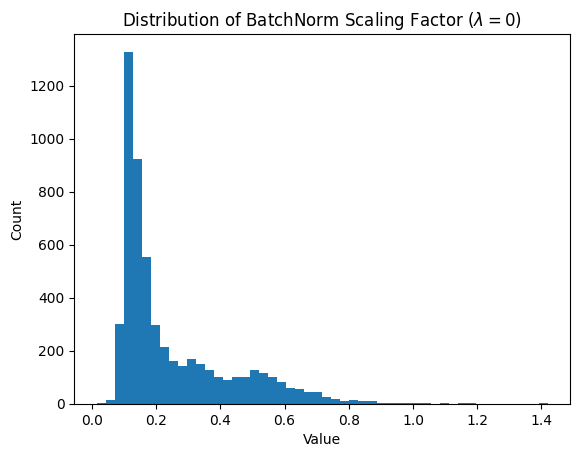

In [ ]:
plot_scaling_factor(model, 'Distribution of BatchNorm Scaling Factor ($\lambda = 0$)', 'images/bn_scale_dist_0.png')

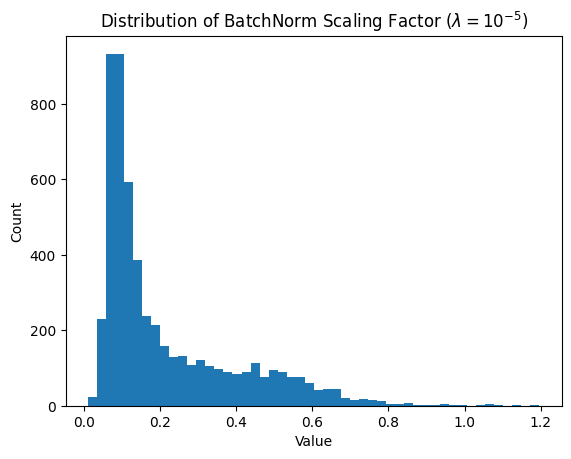

<Figure size 640x480 with 0 Axes>

In [13]:
plot_scaling_factor(model, 'Distribution of BatchNorm Scaling Factor ($\lambda = 10^{-5}$)', 'images/bn_scale_dist_1.png')

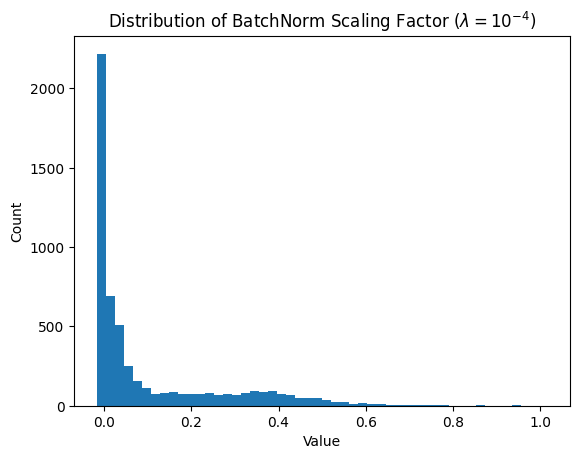

<Figure size 640x480 with 0 Axes>

In [12]:
plot_scaling_factor(model, 'Distribution of BatchNorm Scaling Factor ($\lambda = 10^{-4}$)', 'images/bn_scale_dist_2.png')